In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")

In [3]:
api = wandb.Api(timeout=19)

In [4]:
# List projects
def list_projects(api, entity):
    projects = api.projects(entity)
    print("Projects:")
    for project in projects:
        print(f"- {project.name}")

In [5]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [6]:
list_projects(api, entity='project_danns')

Projects:
- Test
- Luminosity_Brightness_Robustness
- Luminosity
- Vanilla-DANN-MNIST
- Vanilla-DANN-FashionMNIST
- Vanilla-DANN-Contrast
- Homeo-DANN


In [7]:
def same_config(config1, config2):
    keys1 = set(config1.keys())
    keys2 = set(config2.keys())
    common_keys = keys1 & keys2
    for key in common_keys:
        if key == 'normtype':
            continue
        if config1[key] != config2[key]:
            return False
    return True

##### Test Set Luminosity

In [21]:
bright_factor = 0.75
runs_nolayernorm = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": False, "config.normtype": "ln_false",
                                                            "config.use_testset": True})
runs_layernorm = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": False, "config.normtype": "ln_true",
                                                            "config.use_testset": True})

Text(0.5, 1.0, 'Accuracy BF: 0.75')

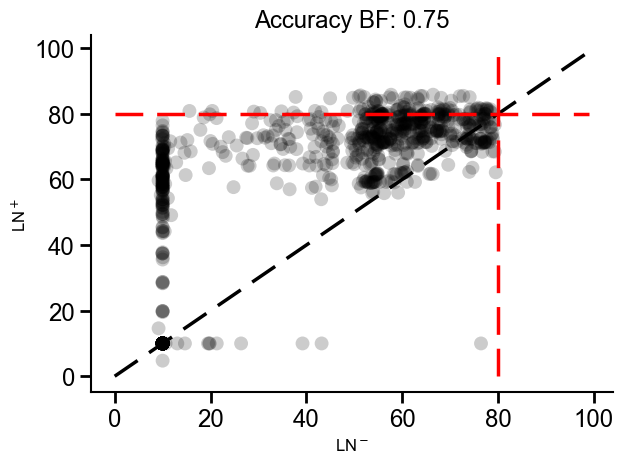

In [22]:
fig, ax = plt.subplots()
test_ln_loss_best = 0
test_noln_loss_best = 0
for run_noln in runs_nolayernorm:
    for run_ln in runs_layernorm:
        if run_ln.summary['test_acc'] > test_ln_loss_best:
            test_ln_loss = run_ln.history(keys=['train_loss'])['train_loss'].values
            test_ln_loss_best = run_ln.summary['test_acc']
        if same_config(run_noln.config, run_ln.config):
            ax.scatter(run_noln.summary['test_acc'], run_ln.summary['test_acc'], alpha=0.2, edgecolors='none', color='black')

    if run_noln.summary['test_acc'] > test_noln_loss_best:
            test_noln_loss = run_noln.history(keys=['train_loss'])['train_loss'].values
            test_noln_loss_best = run_noln.summary['test_acc']
        

list_line = range(100)
list_threshold = [80] * 100
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')
ax.plot(list_line, list_threshold, label='y = x', color='red', linestyle='--')
ax.plot(list_threshold, list_line, label='y = x', color='red', linestyle='--')
ax.set_xlabel("LN$^-$")
ax.set_ylabel("LN$^+$")
ax.set_title(f"Accuracy BF: {bright_factor}")

##### Train Set Luminosity

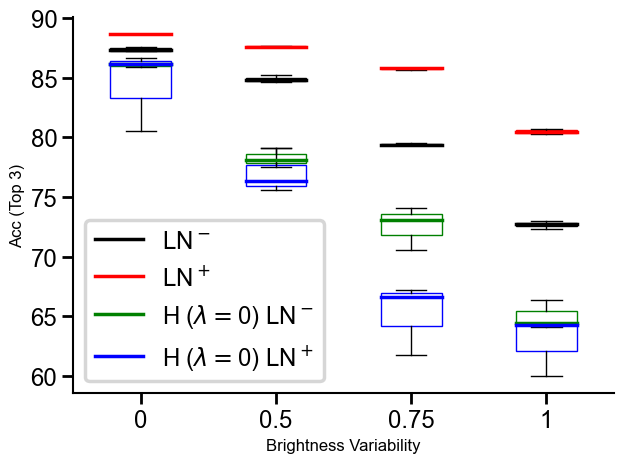

In [26]:
fig, ax = plt.subplots()
brightness_factor = [0, 0.5, 0.75, 1]
best_n_runs = 3
noln_acc = []
ln_acc = []
homeo_acc = []
homeo_ln_acc = []
lmbda=0

for bf in brightness_factor:
    
    runs_nolayernorm_train = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": False, "config.normtype": "ln_false",
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:best_n_runs]
    runs_layernorm_train = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": False, "config.normtype": "ln_true",
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:best_n_runs]
    runs_homeostasis_train = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 1, "config.normtype": "ln_false",
                                                                "config.use_testset": True, "config.lambda_homeo": lmbda}, order="-summary_metrics.test_acc")[:best_n_runs]
    runs_homeostasis_ln_train = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 1, "config.normtype": "ln_true",
                                                                "config.use_testset": True, "config.lambda_homeo": lmbda}, order="-summary_metrics.test_acc")[:best_n_runs]
                                                                
    noln_acc.append([run_noln.summary['test_acc'] for run_noln in runs_nolayernorm_train ])
    ln_acc.append([run_ln.summary['test_acc'] for run_ln in runs_layernorm_train])
    homeo_acc.append([run_ln.summary['test_acc'] for run_ln in runs_homeostasis_train])
    homeo_ln_acc.append([run_ln.summary['test_acc'] for run_ln in runs_homeostasis_ln_train])

bp1 = ax.boxplot(np.array(noln_acc).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                         showbox=True, showfliers=False)
bp2 = ax.boxplot(np.array(ln_acc).T, patch_artist=True, boxprops=dict(color='red', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='red'),
                         showfliers=False)
bp3 = ax.boxplot(np.array(homeo_acc).T, patch_artist=True, boxprops=dict(color='green', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='green'),
                        showfliers=False)
bp4 = ax.boxplot(np.array(homeo_ln_acc).T, patch_artist=True, boxprops=dict(color='blue', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='blue'),
                        showfliers=False)
# Create custom x-axis tick labels
custom_xticks = ['0', '0.5', '0.75', '1']
ax.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax.set_xticklabels(custom_xticks)

ax.set_xlabel('Brightness Variability')
ax.set_ylabel(f'Acc (Top {best_n_runs})')
ax.legend([bp1["medians"][0], bp2["medians"][0], bp3["medians"][0], bp4["medians"][0]], ['LN$^-$', 'LN$^+$', f'H ($\lambda=${lmbda}) LN$^-$', f'H ($\lambda=${lmbda}) LN$^+$'], loc='lower left')
#ax.set_yscale('log')




In [11]:
brightness_factor = [0, 0.25, 0.5, 0.75, 1]
best_n_runs = 10
ln_dif_noln_acc = []

for bf in brightness_factor:
    runs_nolayernorm_train = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": False, "config.normtype": "ln_false",
                                                                "config.use_testset": True})
    runs_layernorm_train = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": False, "config.normtype": "ln_true",
                                                                "config.use_testset": True})
    run_avg = []
    for run_noln in runs_nolayernorm_train:
        for run_ln in runs_layernorm_train:
            if same_config(run_noln.config, run_ln.config):
                run_avg.append(run_ln.summary['test_acc'] - run_noln.summary['test_acc'])
    
    ln_dif_noln_acc.append(run_avg)

/tmp/ipykernel_2915655/2554548379.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bp1 = ax.boxplot(np.array(ln_dif_noln_acc).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),


(-100.0, 100.0)

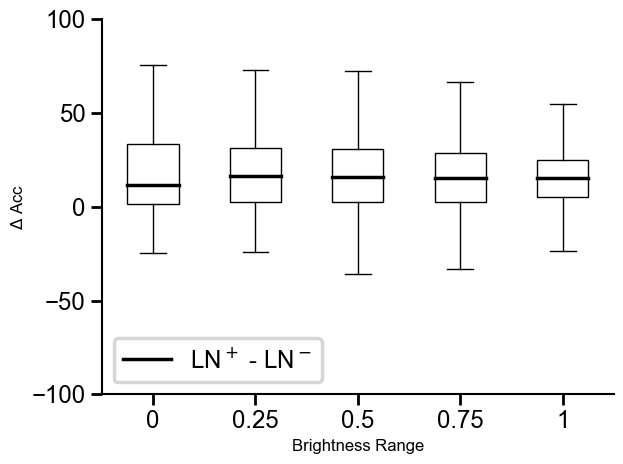

In [13]:
fig, ax = plt.subplots()
bp1 = ax.boxplot(np.array(ln_dif_noln_acc).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                         showbox=True, showfliers=False)
# Create custom x-axis tick labels
custom_xticks = ['0', '0.25', '0.5', '0.75', '1']
ax.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax.set_xticklabels(custom_xticks)

ax.set_xlabel('Brightness Range')
ax.set_ylabel('$\Delta$ Acc')
ax.legend([bp1["medians"][0]], ['LN$^+$ - LN$^-$'], loc='lower left')
ax.set_ylim(-100,100)

In [79]:
len(ln_dif_noln_acc[4])

900

Text(0, 0.5, 'Cross Entropy Loss')

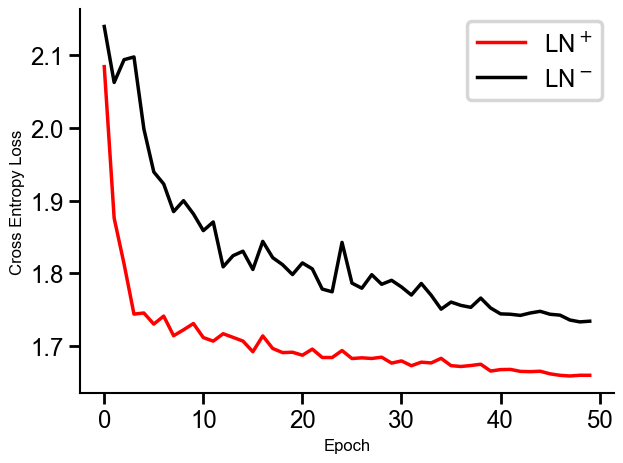

In [18]:
fig, ax = plt.subplots()

# ax.plot(train_ln_loss, color='red')
# ax.plot(train_noln_loss, color='black')
ax.plot(test_ln_loss, color='red', label='LN$^+$')
ax.plot(test_noln_loss, color='black', label='LN$^-$')

# # Define custom legend elements
# legend_elements = [
#     Line2D([0], [0], color='black', markersize=4, lw=2, label='Data Count=50000', linestyle='solid'),
#     Line2D([0], [0], color='black', lw=2, markersize=4, linestyle='dotted', label='Data Count=60000')
# ]
# # Create the legend
# ax.legend(handles=legend_elements, fontsize='medium', markerscale=1)

ax.legend()

ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")

##### OOD Brightness Factor against Accuracy

Text(0, 0.5, 'Accuracy')

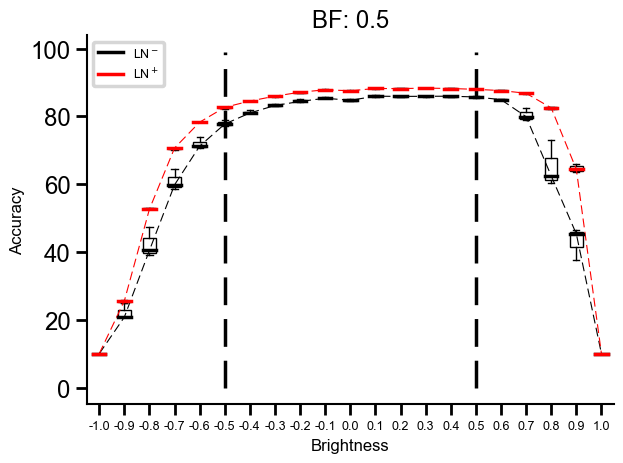

In [12]:
fig, ax = plt.subplots()
brightness_fact = 0.5
bp = {"ln_false": 0, "ln_true": 0}
for idx, normtype in enumerate(['ln_false', 'ln_true']):
    accs = []
    medians = []
    for i in np.linspace(-1,1,21):
        bright_eval = np.round(i, 2)
        runs = fetch_runs(api, entity='project_danns', project_name='Luminosity_Brightness_Robustness', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": brightness_fact, "config.brightness_factor_eval": bright_eval, "config.homeostasis": False, "config.normtype": normtype})

        test_summary = [rn.summary['test_acc'] for rn in runs ]
        accs.append(test_summary)
        medians.append(np.median(test_summary))
        
    
    bp[normtype] = ax.boxplot(np.array(accs).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color=["black", "red"][idx]),
                         showbox=True, showfliers=False)
    ax.plot(np.arange(1, len(medians)+1), medians, color=["black", "red"][idx], linestyle="--", linewidth=0.8)


ax.legend([bp["ln_false"]["medians"][0], bp["ln_true"]["medians"][0]], ['LN$^-$', 'LN$^+$'], loc='upper left', fontsize=9)

x_xs = np.linspace(-1,1,21)
custom_xticks = np.round(x_xs,2)
ax.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax.set_xticklabels(custom_xticks, fontsize=9)

list_line = range(100)
for ii,ix in enumerate(custom_xticks):
    if brightness_fact in [0, 0.5, 1]:
        if brightness_fact == ix: 
            pos_intercept = ii+1

        if ix == -brightness_fact:
            neg_intercept = ii+1
    else:
        bff = brightness_fact+0.05
        if bff == ix: 
            pos_intercept = ii + 0.5

        if ix == -bff:
            neg_intercept = ii + 1.5

pos_list_threshold = [pos_intercept] * 100
neg_list_threshold = [neg_intercept] * 100
ax.plot(pos_list_threshold, list_line, label='y = x', color='black', linestyle='--')
ax.plot(neg_list_threshold, list_line, label='y = x', color='black', linestyle='--')

ax.set_title(f"BF: {brightness_fact}")
ax.set_xlabel("Brightness")
ax.set_ylabel("Accuracy")

[4.449, 2.277499999999999, 8.362, 9.43666666666667]


Text(0.5, 0, 'Brightness Variability')

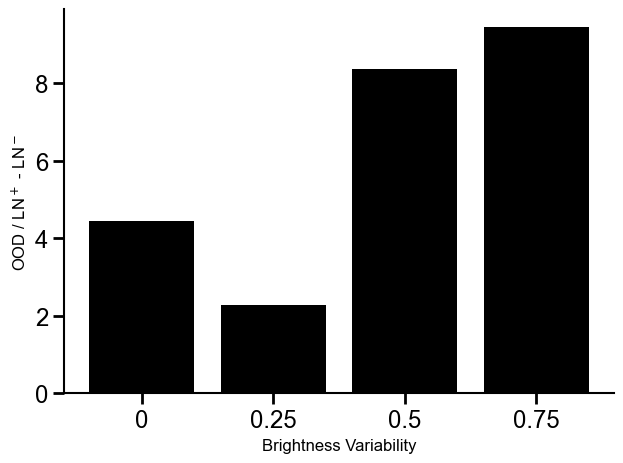

In [67]:
fig, ax = plt.subplots()
brightness_factors = [0, 0.25, 0.5, 0.75]
ood_metrics = []
for brightness_fact in brightness_factors:
    medians = {"ln_false": [], "ln_true": []}
    for idx, normtype in enumerate(['ln_false', 'ln_true']):
        for i in np.linspace(-1,1,21):
            bright_eval = np.round(i, 2)
            runs = fetch_runs(api, entity='project_danns', project_name='Luminosity_Brightness_Robustness', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": brightness_fact, "config.brightness_factor_eval": bright_eval, "config.homeostasis": False, "config.normtype": normtype})

            test_summary = [rn.summary['test_acc'] for rn in runs ]
            if i < -brightness_fact or i > brightness_fact:
                medians[normtype].append(np.median(test_summary))

    ood_metrics.append(np.mean(np.array(medians['ln_true']) - np.array(medians['ln_false'])))

print(ood_metrics)
ax.bar([str(i) for i in brightness_factors], ood_metrics, color='black')
ax.set_ylabel('OOD / LN$^+$ - LN$^-$')
ax.set_xlabel('Brightness Variability')
    


# Homeostasis Analysis

Text(0, 0.5, 'FC1 (Top 10)')

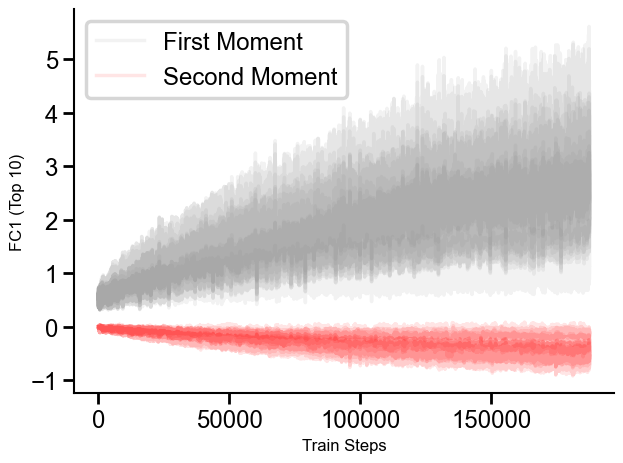

In [9]:
fig, ax = plt.subplots()
brightness_factor = [0.75] #, 0.25, 0.5, 0.75, 1]
best_n_runs = 10
homeo_acc = []

for bf in brightness_factor:
    runs_homeostasis_train = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 1, "config.normtype": "ln_false",
                                                                "config.use_testset": True, "state": "finished"}, order="-summary_metrics.test_acc")[:best_n_runs]
    for idx, run in enumerate(runs_homeostasis_train):
        first_moment = [element for element in run.history()['train_fc1_var'].values if not np.isnan(element)]
        second_moment = [element for element in run.history()['train_fc1_mu'].values if not np.isnan(element)]
        ax.plot(first_moment, color='gray', alpha=0.1, label="First Moment" if idx==0 else None)
        ax.plot(second_moment, color='red', alpha=0.1, label="Second Moment" if idx==0 else None)

ax.legend()
ax.set_xlabel("Train Steps")
ax.set_ylabel("FC1 (Top 10)")

Text(0, 0.5, 'Acc (Top 10)')

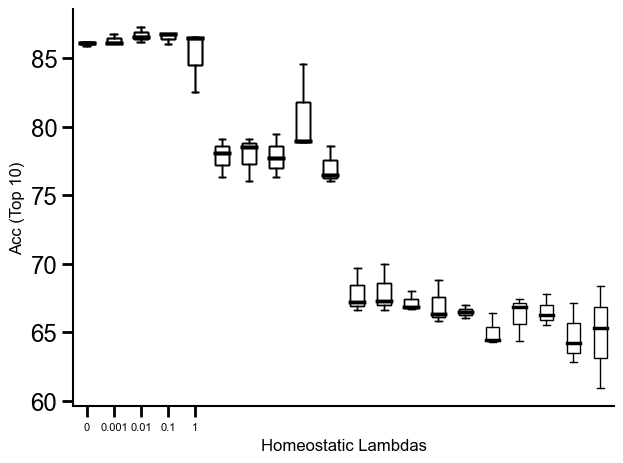

In [11]:
fig, ax = plt.subplots()
brightness_factor = [0, 0.5, 0.75, 1] #, 0.25, 0.5, 0.75, 1]
lmbdas=[0, 0.001, 0.01, 0.1, 1]
best_n_runs = 3
homeo_acc = []

for bf in brightness_factor:
    for lmbda in lmbdas:
        runs_homeostasis_train = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bf, "config.homeostasis": 1, "config.normtype": "ln_false",
                                                                    "config.use_testset": True, "config.lambda_homeo": lmbda}, order="-summary_metrics.test_acc")[:best_n_runs]
        
        homeo_acc.append([run_ln.summary['test_acc'] for run_ln in runs_homeostasis_train])


    ax.boxplot(np.array(homeo_acc).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

# Create custom x-axis tick labels
custom_xticks = [str(el) for el in lmbdas]
ax.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax.set_xticklabels(custom_xticks, fontsize=8)

ax.set_xlabel('Homeostatic Lambdas')
ax.set_ylabel('Acc (Top 10)')
#ax.legend([bp3["medians"][0]], ['H'], loc='lower left')
#ax.set_yscale('log')

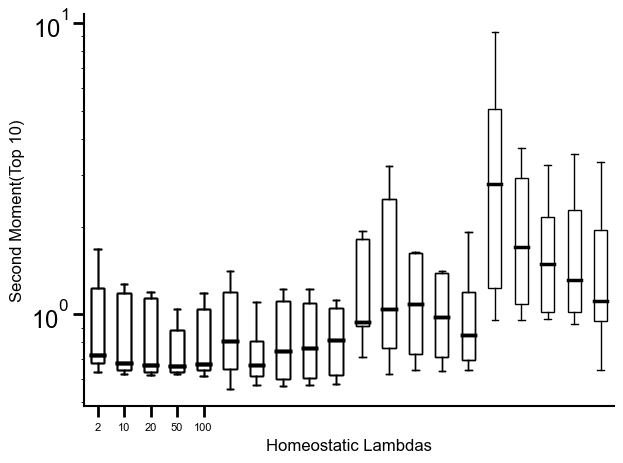

In [11]:
fig, ax = plt.subplots()
brightness_factor = [0, 0.5, 0.75, 1] #, 0.25, 0.5, 0.75, 1]
lmbdas=[0, 0.001, 0.01, 0.1, 1]
lmbdas=[2, 10, 20, 50, 100]
best_n_runs = 10
homeo_acc = []

for bf in brightness_factor:
    for lmbda in lmbdas:
        runs_homeostasis_train = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bf, "config.homeostasis": 1, "config.normtype": "ln_false",
                                                                    "config.use_testset": True, "config.lambda_homeo": lmbda}, order="-summary_metrics.test_acc")[:best_n_runs]
        
        homeo_acc.append([run_ln.summary['eval_fc1_var'] for run_ln in runs_homeostasis_train])


    ax.boxplot(np.array(homeo_acc).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

# Create custom x-axis tick labels
custom_xticks = [str(el) for el in lmbdas]
ax.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax.set_xticklabels(custom_xticks, fontsize=8)

ax.set_xlabel('Homeostatic Lambdas')
ax.set_ylabel('Second Moment(Top 10)')
#ax.legend([bp3["medians"][0]], ['H'], loc='lower left')
ax.set_yscale('log')

### Batch script for running OOD brightness tasks 

In [18]:
permission=False

In [ ]:

import re
import subprocess
import shlex
brightness_factor = [0, 0.25, 0.5, 0.75, 1]
best_n_runs = 3
if permission:
    for bf in brightness_factor:
        for normtype in ['ln_true', 'ln_false']:
            runs = fetch_runs(api, entity='project_danns', project_name='Luminosity', filters={"config.dataset": "fashionmnist", 
                                                                        "config.brightness_factor": bf, "config.homeostasis": False, "config.normtype": normtype,
                                                                        "config.use_testset": True}, order="-summary_metrics.test_acc")[:best_n_runs]

            for run in runs:
            
                lr = run.config['lr']
                r = run.config['lr']
                wd = run.config['wd']
                inhib_momentum = run.config['inhib_momentum']
                momentum = run.config['momentum']
                inhib_weights = re.findall('\d+\.\d+|\d+', run.config['inhib_lrs'])
                                                    
                subprocess.call(shlex.split(f'sbatch ../batch_scripts/run_multiple_brightness_factor.sh {bf} {normtype} {lr} {wd} {inhib_momentum} {momentum} {inhib_weights[0]} {inhib_weights[1]}'))
